We will fine-tune a model (BERT) on a NER task, which will then be able to compute predictions.


# Preparing the data

First things first, we need a dataset suitable for token classification. In this section we will use the [CoNLL-2003 dataset](https://huggingface.co/datasets/conll2003), which contains news stories from Reuters.


## Download CoNLL-2003 dataset

To load the CoNLL-2003 dataset, we use the `load_dataset()` method from the Hugging Face Datasets library. Inspecting this object shows us the columns present and the split between the training, validation, and test sets:

In [1]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

We can see the dataset contains labels for the three tasks we mentioned earlier: **NER**, **POS**, and **chunking**. 

A big difference from other datasets is that the **input texts are not presented as sentences or documents, but lists of words** (the last column is called tokens, but it contains words in the sense that these are pre-tokenized inputs that still need to go through the tokenizer for subword tokenization). Let's have a look:

In [2]:
raw_datasets["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

Since we want to perform named entity recognition, we will look at the **NER tags**:

In [3]:
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

The meaning of the tags is as follows:

- `O` means the word **doesn’t correspond to any entity**.
- `B-PER/I-PER` means the word corresponds to the beginning of/is inside a **person entity**.
- `B-ORG/I-ORG` means the word corresponds to the beginning of/is inside an **organization entity**.
- `B-LOC/I-LOC` means the word corresponds to the beginning of/is inside a **location entity**.
- `B-MISC/I-MISC` means the word corresponds to the beginning of/is inside a **miscellaneous entity**.

If we print an example:

In [4]:
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["ner_tags"]
line1, line2 = "", ""
for word, label_index in zip(words, labels):
    full_label = label_names[label_index]
    # Add spaces to the right to align the words and labels
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

EU    rejects German call to boycott British lamb . 
B-ORG O       B-MISC O    O  O       B-MISC  O    O 


## Processing the data

As usual, our **texts need to be converted to token IDs** before the model can make sense of them. As a big difference in the case of token classification tasks is that we have **pre-tokenized inputs**. Fortunately, the tokenizer API can deal with that pretty easily; we just **need to warn the tokenizer with a special flag**.

In [5]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

You can replace the model_checkpoint with any other model you prefer from the [Hub](https://huggingface.co/models), or with a local folder in which you’ve saved a pretrained model and a tokenizer. The only constraint is that the tokenizer needs to be backed by the Hugging Face Tokenizers library, so there’s a “fast” version available. You can see all the architectures that come with a fast version in [this big table](https://huggingface.co/transformers/#supported-frameworks), and to check that the tokenizer object you’re using is indeed backed by Hugging Face Tokenizers you can look at its `is_fast` attribute:

In [6]:
tokenizer.is_fast

True

To **tokenize a pre-tokenized input**, we can use our tokenizer as usual and just add **`is_split_into_words=True`**:

In [7]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
print(inputs.tokens())

['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']


### Match the tokens with the labels

As we can see, the **tokenizer added the special tokens** used by the model (`[CLS]` at the beginning and `[SEP]` at the end) and left most of the words untouched. The word lamb, however, was **tokenized into** two **subwords**, `la` and `##mb`. This introduces a mismatch between our inputs and the labels: **the list of labels has only 9 elements, whereas our input now has 12 tokens**. Accounting for the special tokens is easy (we know they are at the beginning and the end), but we also need to **make sure we align all the labels with the proper words**.

In [8]:
print(f"Example has {len(raw_datasets['train'][0]['tokens'])} words.")
print(f"Example is tokenized to {len(inputs['input_ids'])} tokens.")
print(f"Example number of labels is {len(raw_datasets['train'][0]['ner_tags'])}.")

Example has 9 words.
Example is tokenized to 12 tokens.
Example number of labels is 9.


Fortunately, because we’re using a fast tokenizer we have access to the Hugging Face Tokenizers superpowers, which means we can easily map each token to its corresponding word:

In [9]:
inputs.word_ids()  # Assignments of input tokens to words

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

With a tiny bit of work, we can then **expand our label list to match the tokens**. The first rule we’ll apply is that **special tokens get a label of `-100`**. This is because by default `-100` is an index that is **ignored** in the loss function we will use (cross entropy). Then, **each token gets the same label as the token that started the word it’s inside**, since they are part of the same entity. For tokens **inside** a word but not at the beginning, we **replace the `B-` with `I-`** (since the token does not begin the entity):

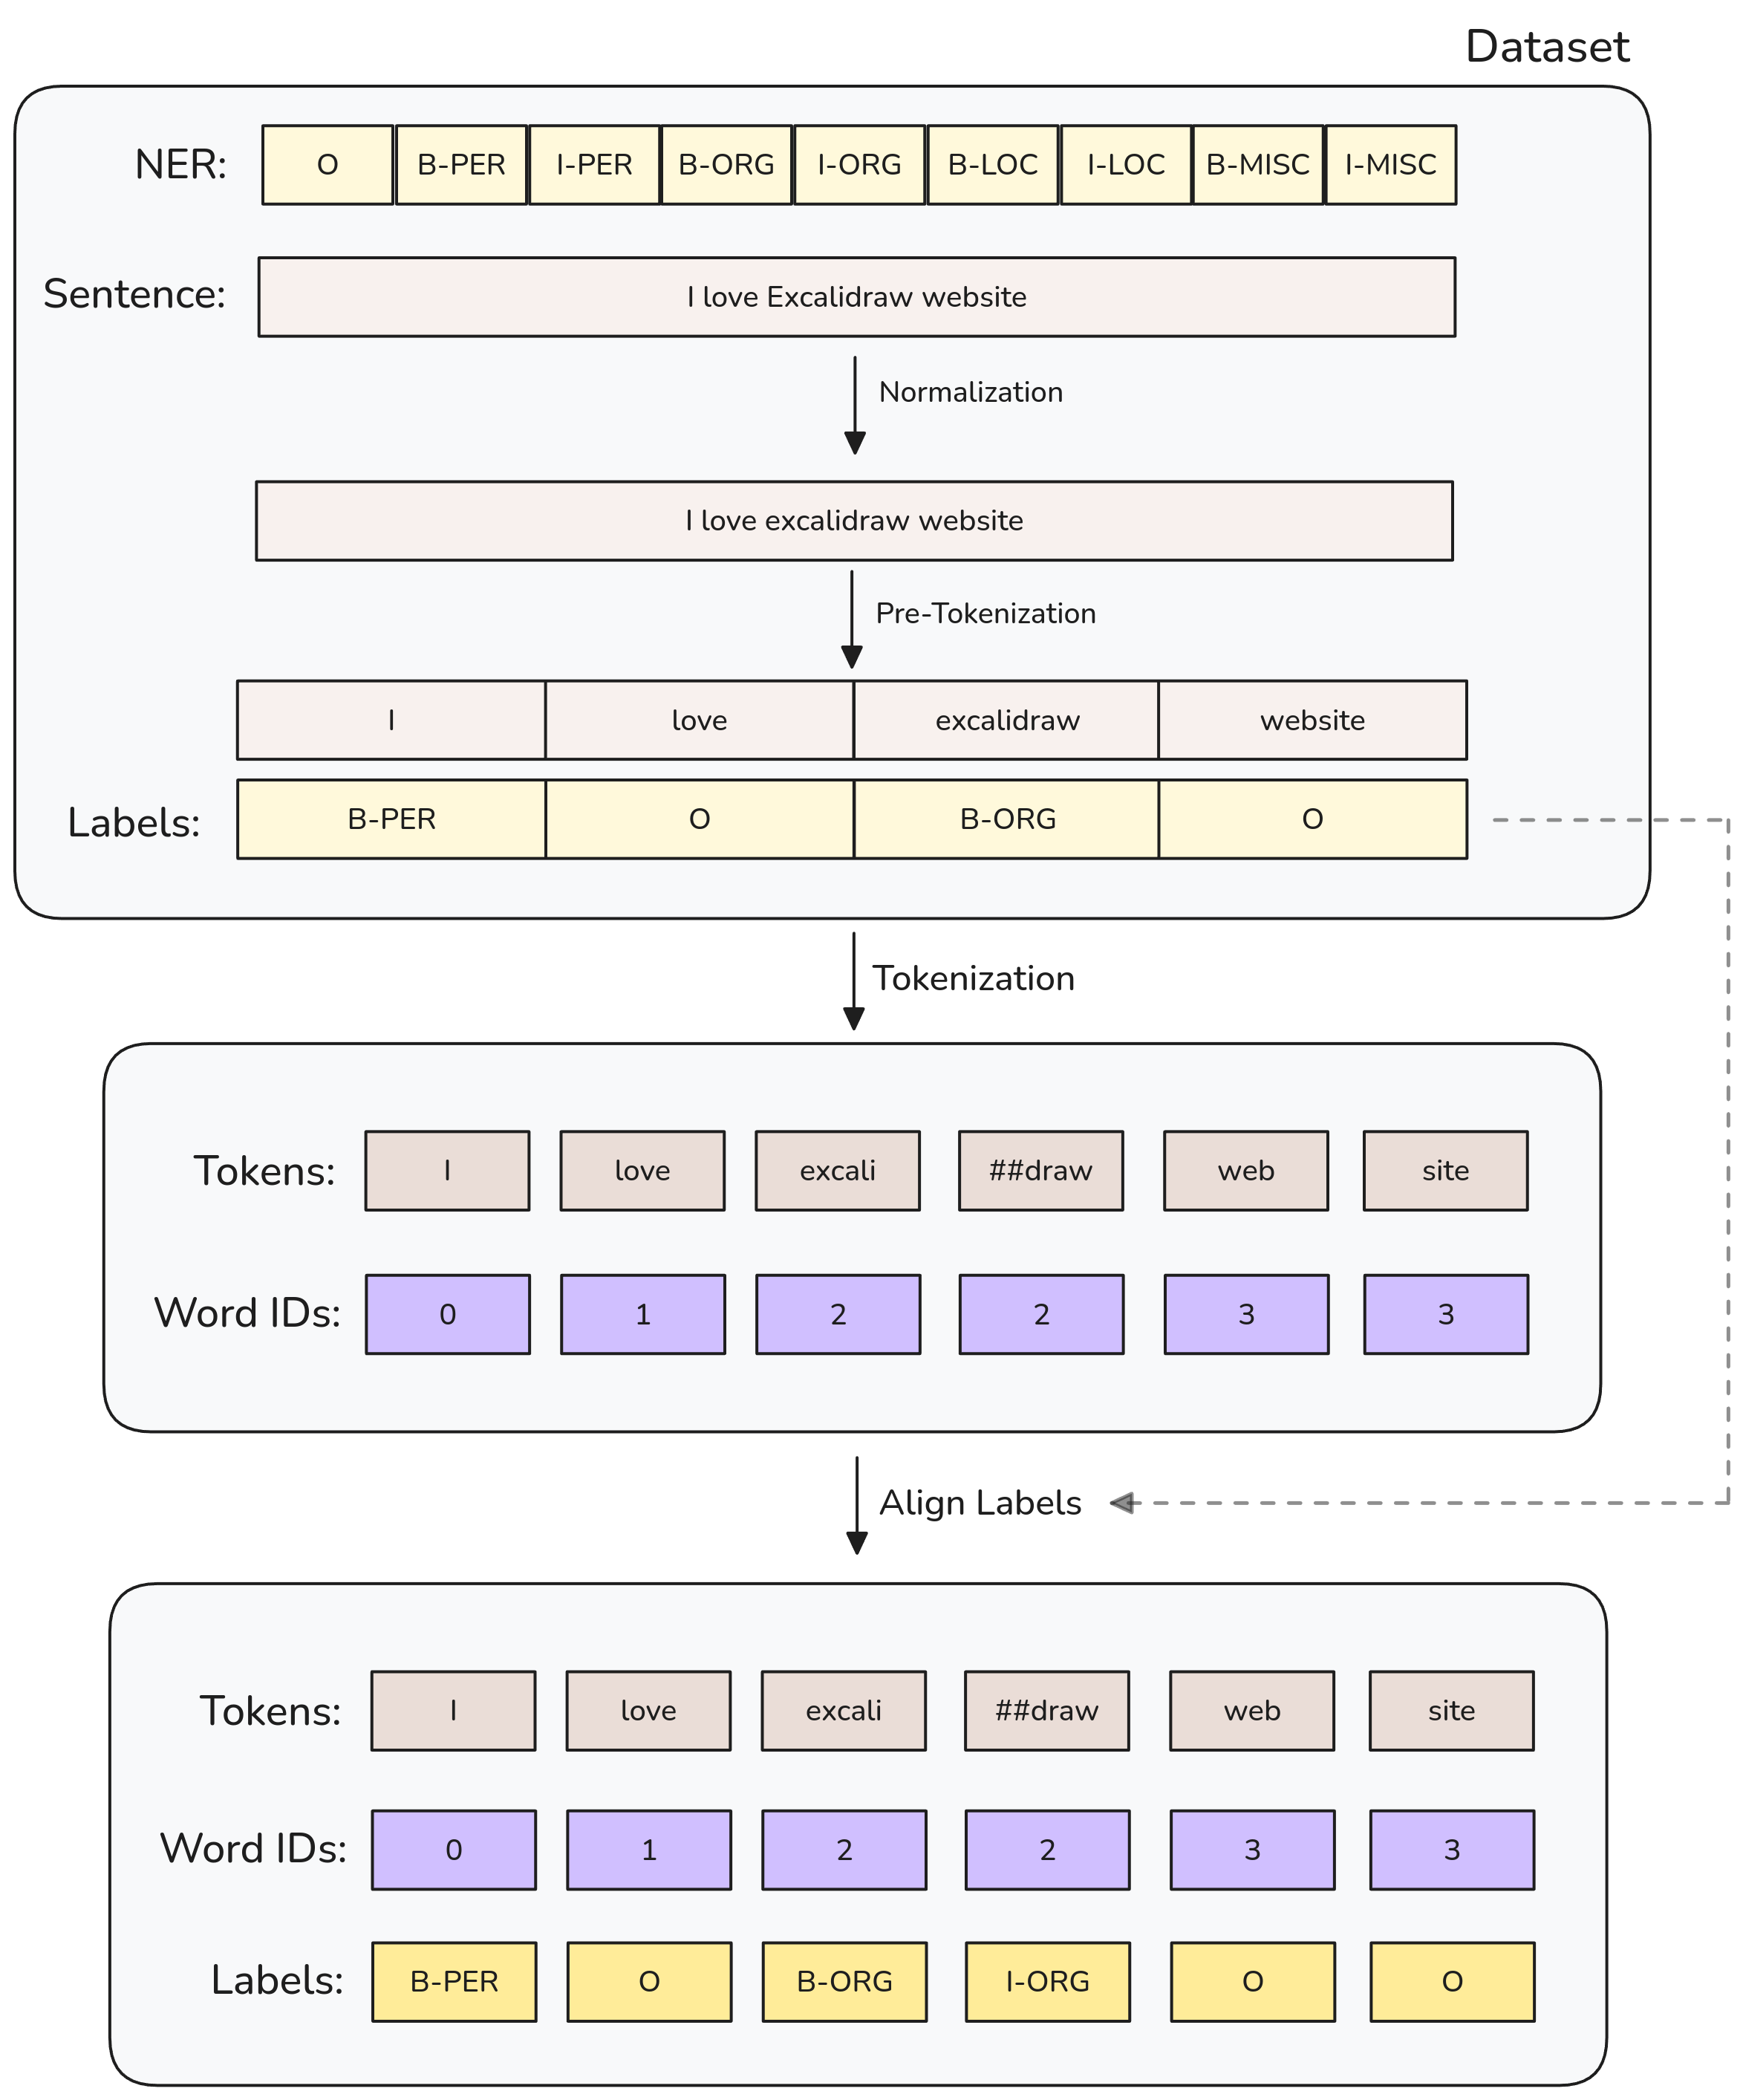

In [10]:
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [11]:
from typing import Any

def align_labels_with_tokens(labels: list[int], word_ids: list[Any]) -> list[int]:
    """
    This function aligns the labels with the word_ids.

    Args:
        labels (list[int]): The original labels.
        word_ids (list[Any]): The word_ids from the tokenizer.

    Returns:
        list[int]: The aligned labels.

    Example:
        labels = [3,0,7,0]
        word_ids = [None, 0, 0, 1, 2, 3, None]
        align_labels_with_tokens(labels, word_ids)
        # Output: [-100, 3, 4, 0, 7, 0, -100]
    """
    new_labels = []  # List to store the aligned labels
    current_word = None  # Track current word to assign 'Inside' labels
    for word_id in word_ids:  # The final labels will have same length as word_ids
        if word_id != current_word:  # Start of a new word!
            current_word = word_id  # Update current
            # Get the label of the current word
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)  # Append the label
        elif word_id is None:  # Special tokens (CLS, SEP, ...)
            new_labels.append(-100)  # Append -100 for special tokens
        else:  # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:  # The odd labels are 'Begin' labels
                # For a given B-XXX label,
                # the +1 is the corresponding I-XXX label
                label += 1
            new_labels.append(label)  # Append the label

    return new_labels

Let's try it out on the first example:

In [12]:
labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(f"Inital labels: {labels}")
print(f"Word IDs: {word_ids}")
print(f"Final labels: {align_labels_with_tokens(labels, word_ids)}")

Inital labels: [3, 0, 7, 0, 0, 0, 7, 0, 0]
Word IDs: [None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]
Final labels: [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


> Some researchers prefer to attribute **only one label per word**, and assign -100 to the other subtokens in a given word. This is to avoid long words that split into lots of subtokens contributing heavily to the loss.

### Tokenize all inputs

To preprocess our whole dataset, we need to tokenize all the inputs and apply `align_labels_with_tokens()` on all the labels. To take advantage of the speed of our fast tokenizer, it’s best to tokenize lots of texts at the same time, so we’ll write a function that **processes a list of examples** and use the `Dataset.map()` method with the option `batched=True`. The only thing that is different from our previous example is that the `word_ids()` function needs to get the index of the example we want the word IDs of when the inputs to the tokenizer are lists of texts (or in our case, list of lists of words), so we add that too:

In [13]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]  # list of list of labels
    new_labels = []  # Generate new labels in list of list of new labels
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

**Note that we haven’t padded our inputs yet; we’ll do that later, when creating the batches with a data collator.**

We can now apply all that preprocessing in one go on the other splits of our dataset:



In [ ]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

# Fine-tuning the model with the Trainer API

The actual code using the Trainer will be the same as before; the only changes are the way the data is collated into a batch and the metric computation function.

## Data collation

We can’t just use a `DataCollatorWithPadding` because that **only pads the inputs** (input IDs, attention mask, and token type IDs). Here **our labels should be padded the exact same way as the inputs so that they stay the same size, using -100 as a value so that the corresponding predictions are ignored in the loss computation**.

This is all done by a [`DataCollatorForTokenClassification`](https://huggingface.co/transformers/main_classes/data_collator.html#datacollatorfortokenclassification).

In [15]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    label_pad_token_id=-100  # The default value is already -100
)

To test this on a few samples, we can just call it on a list of examples from our tokenized training set:

In [16]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

As we can see, the second set of labels has been padded to the length of the first one using -100s.

## Metrics

To have the `Trainer` compute a metric every epoch, we will need to define a `compute_metrics()` function that takes the arrays of predictions and labels, and returns a dictionary with the metric names and values.

The traditional framework used to evaluate token classification prediction is [seqeval](https://github.com/chakki-works/seqeval). We can then load it via the `evaluate.load()` function:

In [ ]:
import evaluate

metric = evaluate.load("seqeval")

This metric does not behave like the standard accuracy: it will actually take the lists of labels as strings, not integers, so we will need to fully decode the predictions and labels before passing them to the metric. Let’s see how it works. First, we’ll get the labels for our first training example:

In [18]:
labels = raw_datasets["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

We can then create fake predictions for those by just changing the value at index 2:

In [19]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

{'MISC': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.8888888888888888}

This is sending back a lot of information! We get the precision, recall, and F1 score for each separate entity, as well as overall.

## Defining the model

Since we are working on a token classification problem, we will use the `AutoModelForTokenClassification` class. The main thing to remember when defining this model is to pass along some **information on the number of labels we have**. The easiest way to do this is to pass that number with the num_labels argument, but it’s better to set the correct **label correspondences** instead.

They should be set by two dictionaries, `id2label` and `label2id`, which contain the mappings from ID to label and vice versa:

In [20]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

Now we can just pass them to the `AutoModelForTokenClassification.from_pretrained()` method, and they will be set in the model’s configuration and then properly saved and uploaded to the Hub:

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,  # "bert-base-cased"
    id2label=id2label,
    label2id=label2id,
)

Like when we defined our AutoModelForSequenceClassification in Chapter 3, creating the model issues a warning that some weights were not used (the ones from the pretraining head) and some other weights are randomly initialized (the ones from the new token classification head), and that this model should be trained. We will do that in a minute, but first let’s **double-check that our model has the right number of labels**:

In [22]:
model.config.num_labels

9

> ⚠️ If you have a model with the wrong number of labels, you will get an obscure error when calling the Trainer.train() method later on (something like “CUDA error: device-side assert triggered”). This is the number one cause of bugs reported by users for such errors, so make sure you do this check to confirm that you have the expected number of labels.

## A custom training loop

Let’s now take a look at the full training loop, so you can easily customize the parts you need.

### Preparing everything for training

First we need to build the **DataLoaders** from our datasets. We’ll reuse our `data_collator` as a `collate_fn` and shuffle the training set, but not the validation set:

In [23]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"],
    collate_fn=data_collator,
    batch_size=BATCH_SIZE
)

Then we will need an optimizer. We’ll use the classic `AdamW`, which is like Adam, but with a fix in the way weight decay is applied:

In [24]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

Once we have all those objects, we can send them to the `accelerator.prepare()` method:

In [25]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

Now that we have sent our `train_dataloader` to `accelerator.prepare()`, we can use its length to compute the number of training steps. Remember that we should always do this after preparing the dataloader, as that method will change its length. We use a classic linear schedule from the learning rate to 0:

In [26]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

### Training loop

We are now ready to write the full training loop. To simplify its evaluation part, we define this `postprocess()` function that takes predictions and labels and converts them to lists of strings, like our metric object expects:

In [27]:
def postprocess(predictions, labels):
    list_predictions = predictions.detach().cpu().clone().numpy()
    list_labels = labels.detach().cpu().clone().numpy()

    # Transform ground truth and predictions int labels to their names
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [
        [
            label_names[label]  # Retrieve label name
            for label in case_labels
            if label != -100  # Discard special tokens
        ]
        for case_labels in list_labels
    ]
    true_predictions = [
        [
            label_names[pred]  # Retrieve label name
            for (pred, label) in zip(case_prediction, case_label)
            if label != -100  # Discard special tokens
        ]
        for case_prediction, case_label in zip(list_predictions, list_labels)
    ]
    return true_labels, true_predictions

Then we can write the training loop. After defining a progress bar to follow how training goes, the loop has three parts:

- The **training** in itself, which is the classic iteration over the train_dataloader, forward pass through the model, then backward pass and optimizer step.
- The **evaluation**, in which there is a novelty after getting the outputs of our model on a batch: since two processes may have padded the inputs and labels to different shapes, we need to use `accelerator.pad_across_processes()` to make the predictions and labels the same shape before calling the `gather()` method. If we don’t do this, the evaluation will either error out or hang forever. Then we send the results to `metric.add_batch()` and call `metric.compute()` once the evaluation loop is over.
- **Saving**, where we save the model and the tokenizer.

In [28]:
from tqdm.auto import tqdm
import torch

output_dir = f"tmp/ner-pt_finetuning-{model_checkpoint}"
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    ###############################################################
    ######################### TRAINING ############################
    ###############################################################
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    ###############################################################
    ######################### EVALUATION ##########################
    ###############################################################
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        # We could have multiple batches on each device with different lengths
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)
        
        # Gather all predictions and labels
        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        # Post-process predictions and labels and update metric
        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    ###############################################################
    ######################### SAVE MODEL ##########################
    ###############################################################
    accelerator.wait_for_everyone()  # Make sure everyone has finished training
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    tokenizer.save_pretrained(output_dir)

  0%|          | 0/5268 [00:00<?, ?it/s]

epoch 0: {'precision': 0.9328508919555705, 'recall': 0.9180192116594899, 'f1': 0.9253756260434056, 'accuracy': 0.9826779301819039}
epoch 1: {'precision': 0.9447997307303938, 'recall': 0.9325581395348838, 'f1': 0.938639023574653, 'accuracy': 0.9854153175958086}
epoch 2: {'precision': 0.947997307303938, 'recall': 0.9290780141843972, 'f1': 0.9384423157017909, 'accuracy': 0.9864308000235474}


Regarding model saving, the first line is self-explanatory: it tells all the processes to wait until everyone is at that stage before continuing. This is to make sure we have the same model in every process before saving. Then we grab the unwrapped_model, which is the base model we defined. The `accelerator.prepare()` method changes the model to work in distributed training, so it won’t have the `save_pretrained()` method anymore; the `accelerator.unwrap_model()` method undoes that step. Lastly, we call `save_pretrained()` but tell that method to use `accelerator.save()` instead of `torch.save()`.

# Using the fine-tuned model

If we [uploaded the model to the Hub](https://huggingface.co/learn/nlp-course/chapter7/2?fw=pt#metrics) we could use it with a `pipeline`!

In [29]:
sentence = "My name is Mario Parreño and I work at Cognizant in Valencia"
inputs = tokenizer(sentence, return_tensors="pt")
inputs.to(model.device)
outputs = model(**inputs)
pred = outputs.logits.argmax(dim=-1)
out = [label_names[i] for i in pred[0].tolist()]

In [30]:
words = inputs.tokens()
labels = out
line1, line2 = "", ""
for word, label_name in zip(words, labels):
    # Add spaces to the right to align the words and labels
    max_length = max(len(word), len(label_name))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += label_name + " " * (max_length - len(label_name) + 1)

print(line1)
print(line2)

[CLS] My name is Mario Pa    ##rre ##ño  and I work at Co    ##gni ##zan ##t   in Valencia [SEP] 
O     O  O    O  B-PER I-PER I-PER I-PER O   O O    O  B-ORG I-ORG I-ORG I-ORG O  B-LOC    O     


We still would need to take care about grouping the tokens back into words (which is easily done by the `pipeline` itself), or implement it ourselves if we want to use the model directly. For more information and a sample implementation check the [Tokenizers Offsets Notebook](../../basics/hf_tokenizers_offsets_ner.ipynb).

In [31]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = output_dir
token_classifier = pipeline(
    "token-classification",
    model=model_checkpoint,
    aggregation_strategy="simple",
    device=0,  # GPU device
)

In [32]:
token_classifier(sentence)

[{'entity_group': 'PER',
  'score': 0.99836,
  'word': 'Mario Parreño',
  'start': 11,
  'end': 24},
 {'entity_group': 'ORG',
  'score': 0.97948956,
  'word': 'Cognizant',
  'start': 39,
  'end': 48},
 {'entity_group': 'LOC',
  'score': 0.9494515,
  'word': 'Valencia',
  'start': 52,
  'end': 60}]